# Testing the Trained WGAN Model

This notebook is designed to test the pretrained Conditional GAN model (built using the library in this project) for video prediction tasks. It is implemented to predict and generate future frames in a video sequence.

In particular, this notebook allows you to:
- Test and evaluate the results of the model
- Use the model recursively to generate new predictions by feeding previous predictions as inputs
- View statistics on the generated data
- Generate GIFs to better visualize the produced results

**To run this notebook,** add the `saved_model` and `data` folders to `ConditionalGANs/ConditionalGANs`.

In [17]:
DATASET = 'no_obj'
SAVE_PATH = 'test_results/no_obj'

In [18]:
!pip install -r requirements.txt

  Using cached tensorflow-2.12.1-cp310-cp310-win_amd64.whl.metadata (2.5 kB)
  Using cached keras-2.13.1rc0-py3-none-any.whl.metadata (2.4 kB)
  Using cached scikit_learn-1.5.0-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Using cached numpy-1.22.0-cp310-cp310-win_amd64.whl.metadata (2.1 kB)


ERROR: Could not find a version that satisfies the requirement cv2==4.5.4 (from versions: none)

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for cv2==4.5.4


### Load Model and Dataset

In [19]:
from tensorflow.keras.models import load_model

if DATASET == 'obj':
    generator = load_model('saved_model/generatorwgan_train_obj.h5')
    discriminator = load_model('saved_model/discriminatorwgan_train_obj.h5')
    DATA_PATH = 'data/new_data_obj.pkl'
else:
    generator = load_model('saved_model/generatorwgan_train_no_obj.h5')
    discriminator = load_model('saved_model/discriminatorwgan_train_no_obj.h5')
    DATA_PATH = 'data/new_data_no_obj.pkl'

In [20]:
from src.wgan import WassersteinGAN

len_input_seq = 6
len_generated_seq = 6

gan = WassersteinGAN( # default parameters
    generator=generator,
    discriminator=discriminator,
    len_input_seq=len_input_seq,
    len_generated_seq=len_generated_seq,
    patience=3,
    learning_rate_generator=0.005,
    learning_rate_discriminator=0.01,
    n_critic=5,  # number of critic updates per generator update
    clip_value=0.01,
    discriminator_gradient_penalty_weight=0.02,
    generator_wloss_weight=0.2,
    generator_flow_loss_weight=0.15,
    generator_mse_weight=0.6,
    color_weight=0.05,
)

In [21]:
def get_data():
    import pickle

    with open(DATA_PATH, 'rb') as f:
        X_train, cX_train, X_train_z = pickle.load(f)

    # split the training set into training and validation
    n_sample_train = int(X_train.shape[0] * 0.8)

    X_train, X_val = X_train[:n_sample_train], X_train[n_sample_train:]
    cX_train, cX_val = cX_train[:n_sample_train], cX_train[n_sample_train:]
    X_train_z, X_val_z = X_train_z[:n_sample_train], X_train_z[n_sample_train:]

    len_input_seq = X_train.shape[1] # 6
    len_generated_seq = 6

    return X_train, X_val, X_train_z, X_val_z, cX_train, cX_val, len_input_seq, len_generated_seq

X_train, X_val, X_train_z, X_val_z, cX_train, cX_val, len_input_seq, len_generated_seq = get_data()

In [22]:
X_train.shape, X_val.shape

((574, 6, 3, 64, 64), (144, 6, 3, 64, 64))

### Visualize results

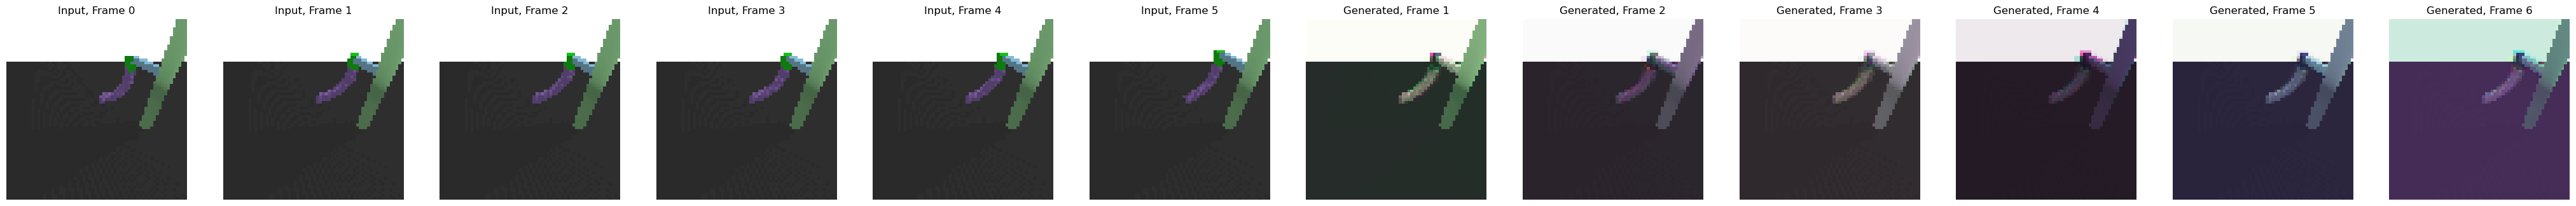

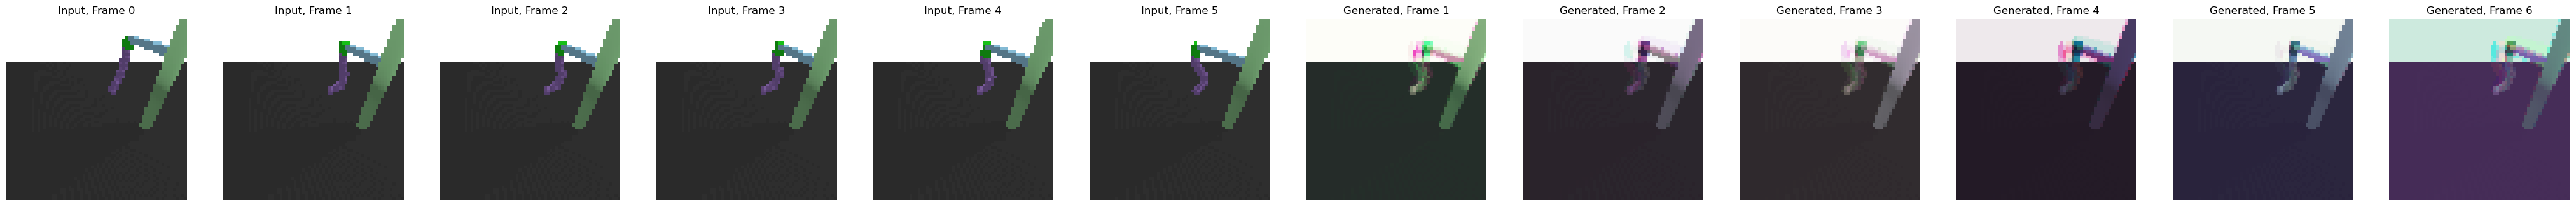

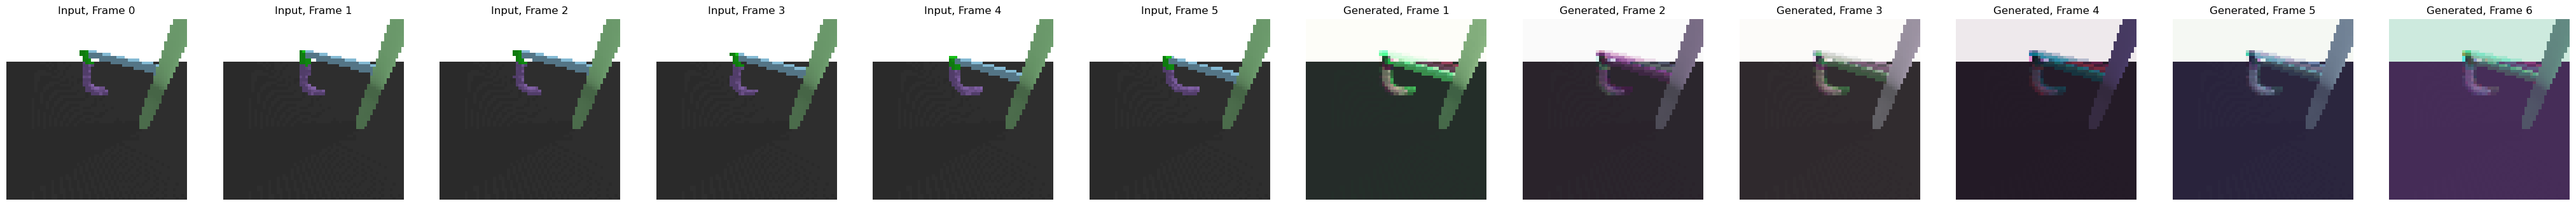

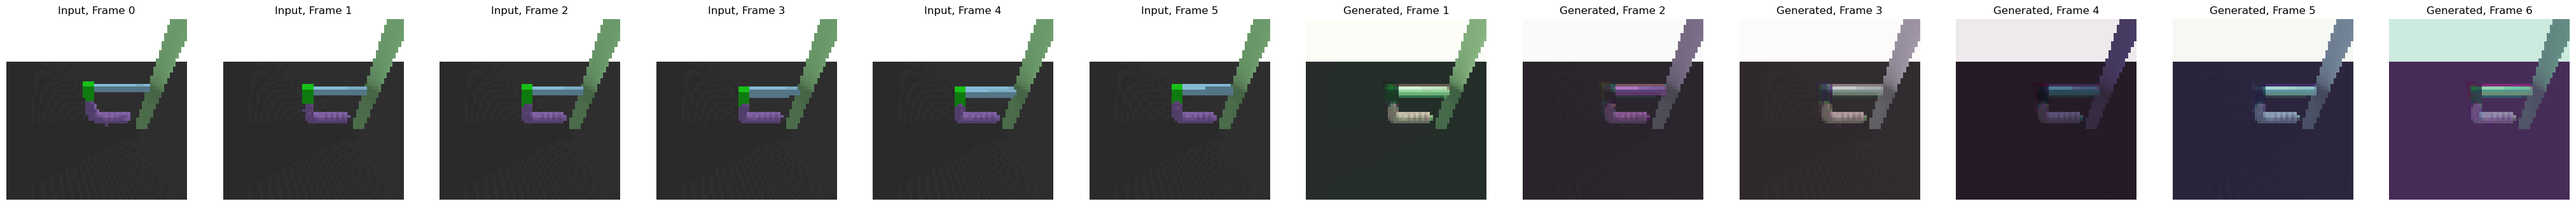

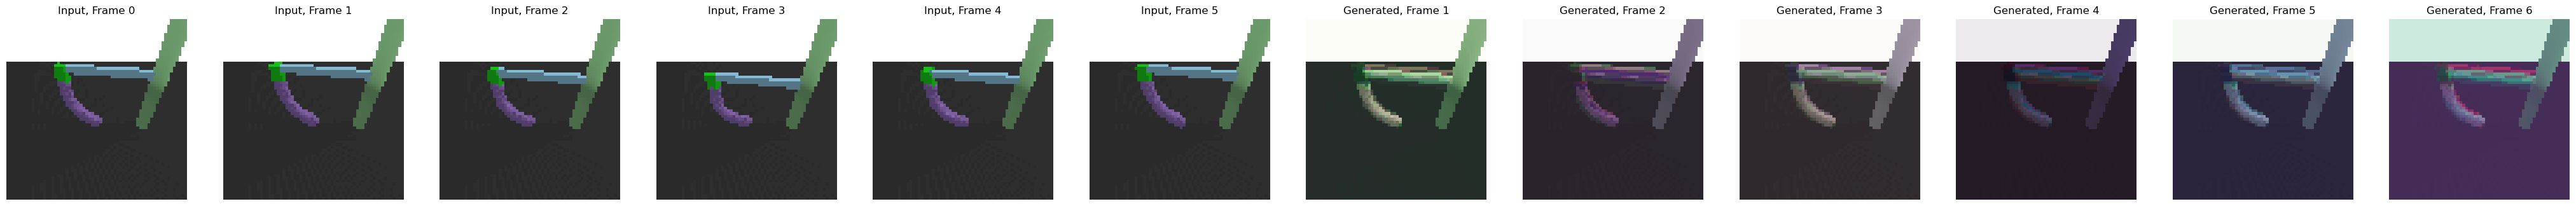

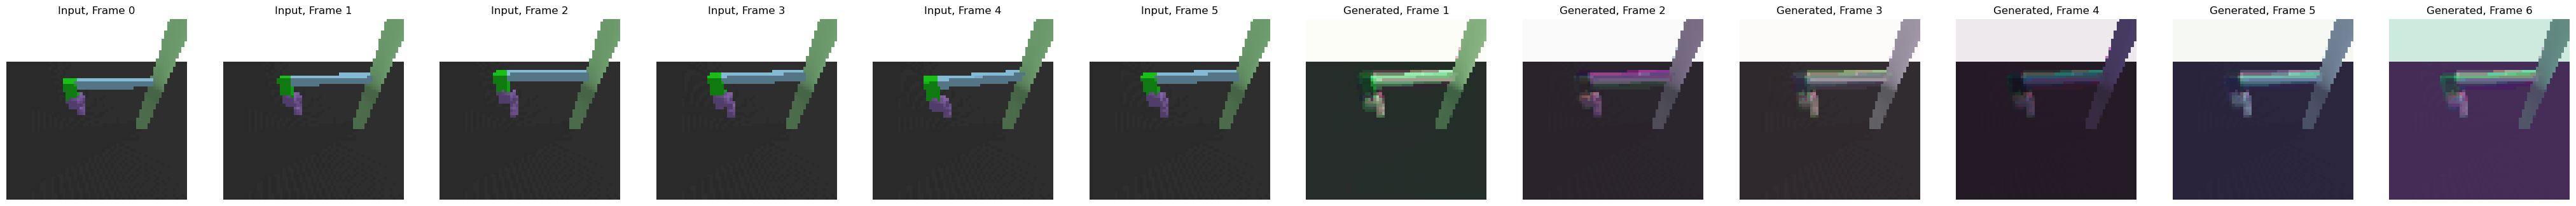

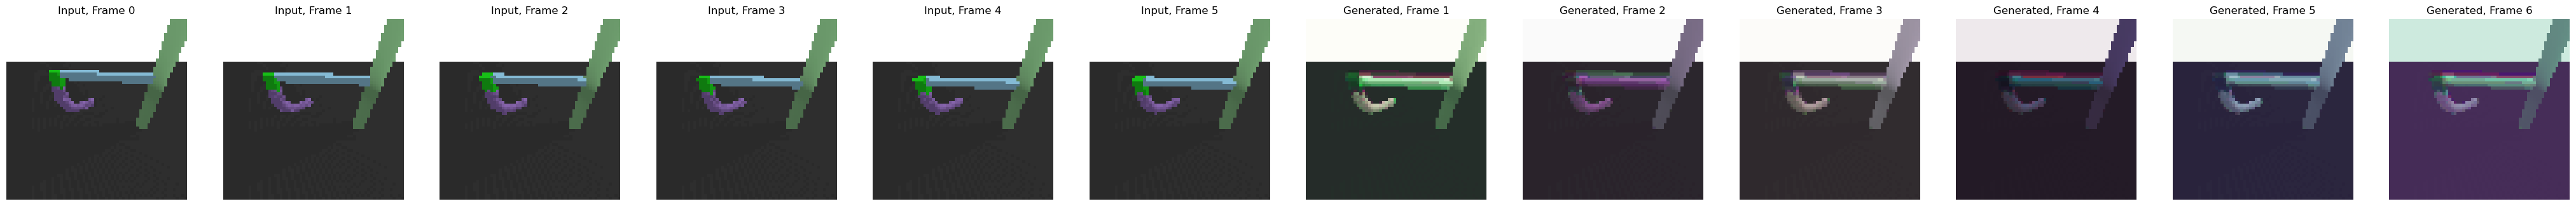

In [23]:
for i in range(1, 141, 20):
    X = X_val[i]
    z = X_val_z[i]
    cX = cX_val[i]

    generated_images = gan.generate(X, z, cX)[0]
    gan.visualize_generated_image(X, z, cX)

### Using the Model Recursively

This section demonstrates how to use the pretrained Conditional GAN model recursively for video prediction tasks. By feeding the model's previous predictions as inputs for subsequent frames, we can generate extended sequences of future frames, allowing the model to iteratively build upon its own outputs. This approach provides insight into the model’s ability to maintain consistency and accuracy over extended time steps in the generated video sequence.

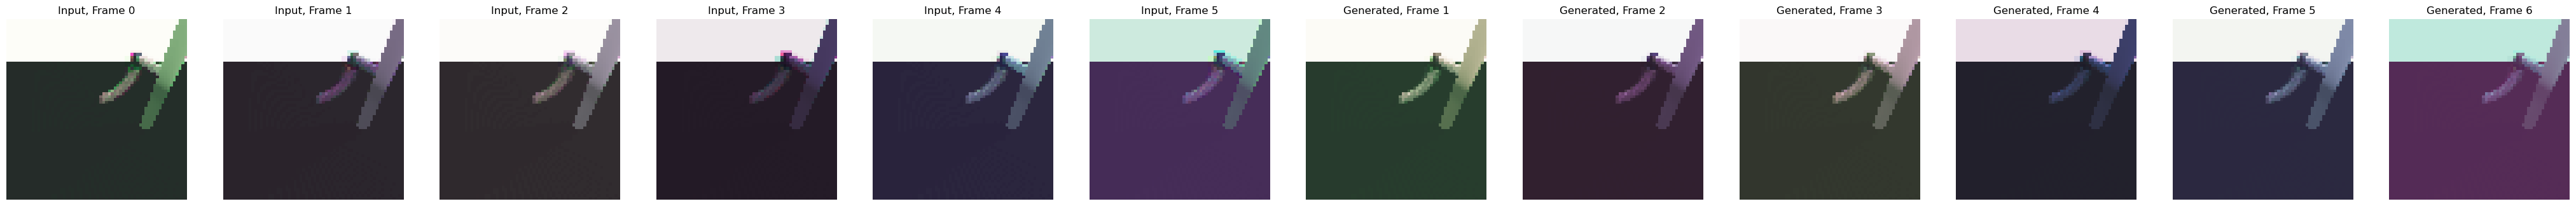

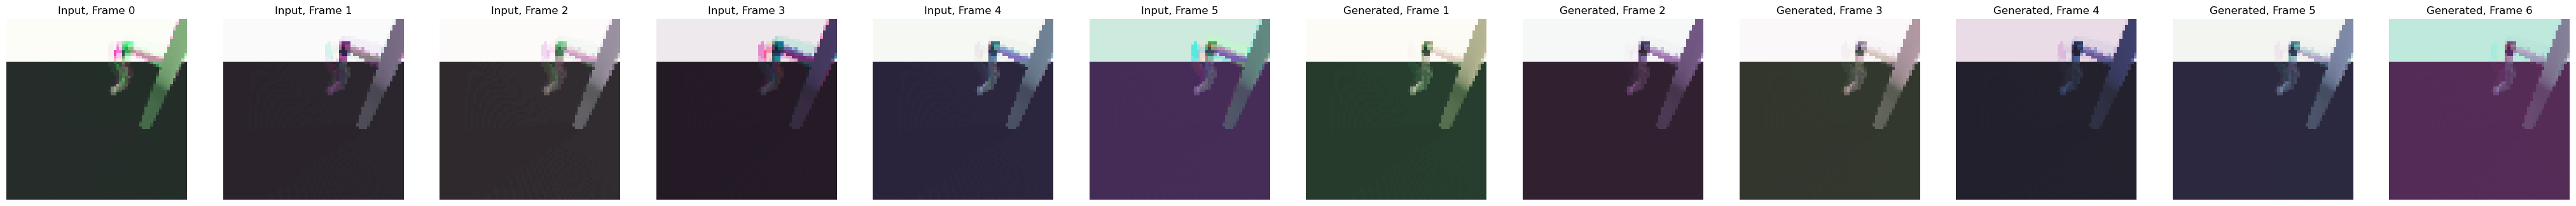

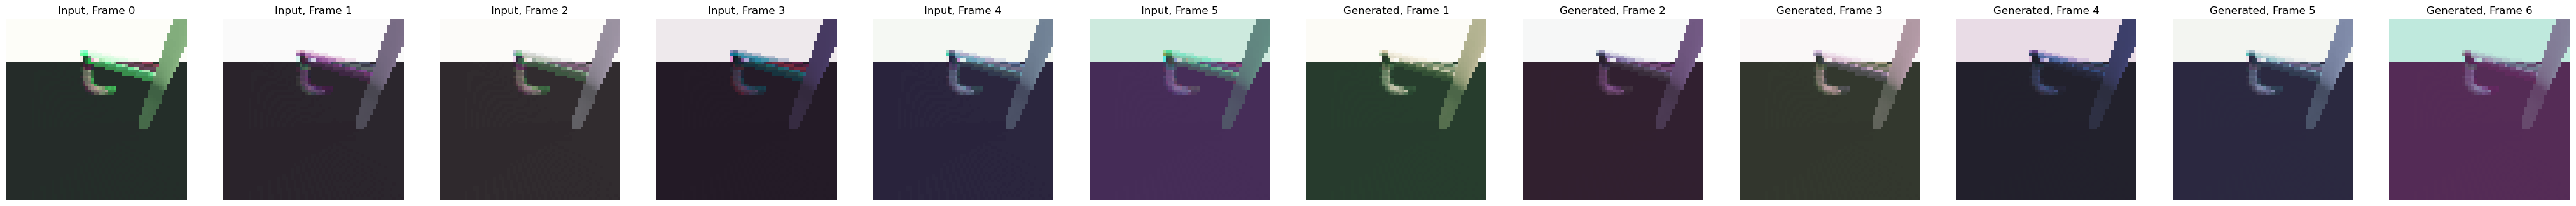

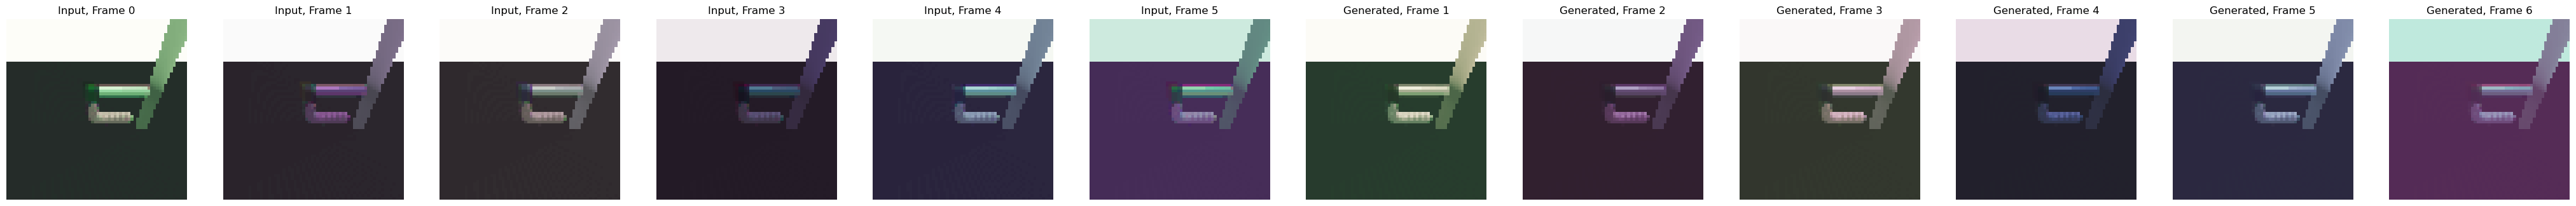

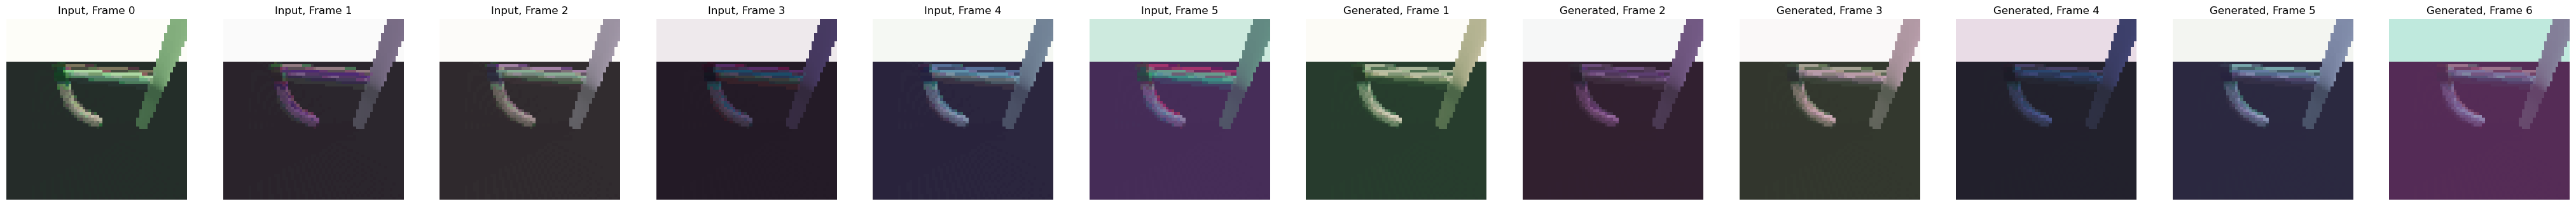

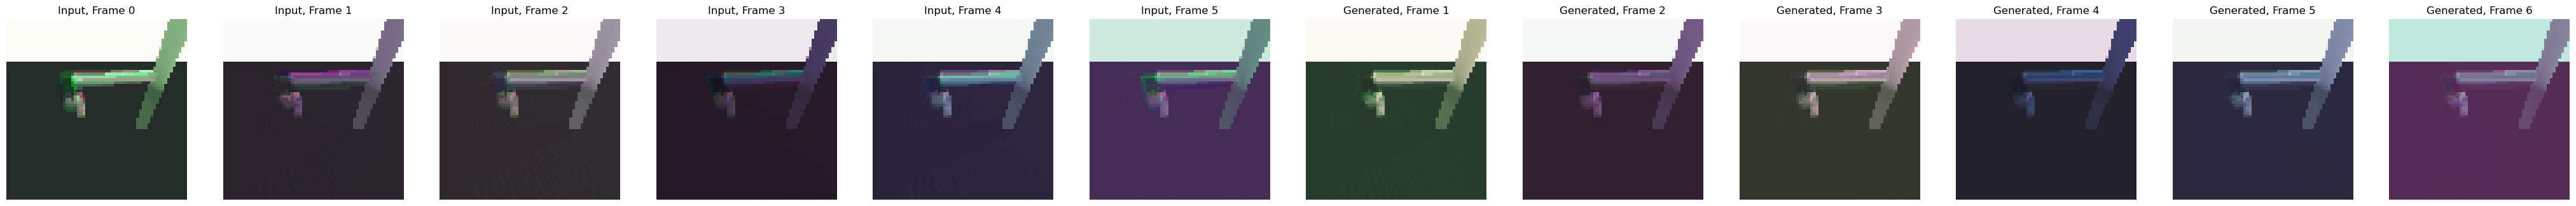

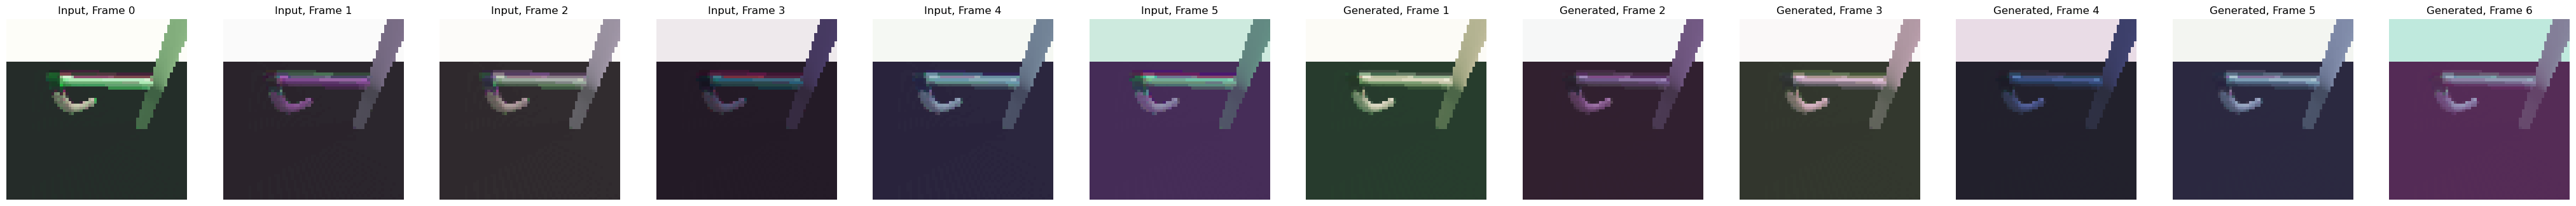

In [24]:
for i in range(1, 141, 20):
    X = X_val[i]
    z = X_val_z[i]
    cX = cX_val[i]

    generated_images = gan.generate(X, z, cX)[0]
    gan.visualize_generated_image(generated_images, z, cX)

### Statistics

This section presents a statistical comparison between the generated data distributions and the true data distributions, including:
- Mean
- Standard deviation
- Minimum and maximum values
- Quantiles

These metrics allow us to evaluate how closely the generated probability distributions align with those of the real data, providing insight into the model's performance in generating realistic samples.

In [25]:
import pickle

with open(DATA_PATH, 'rb') as f:
    # whole dataset
    X_train_all, cX_train_all, X_train_z_all = pickle.load(f)

In [26]:
X_train_all.shape, cX_train_all.shape, X_train_z_all.shape

((718, 6, 3, 64, 64), (718, 5, 6), (718, 6, 1280))

In [27]:
generated_all_images = generator.predict([X_train_all, X_train_z_all, cX_train_all])

23/23 [==============================] - 2s 74ms/step


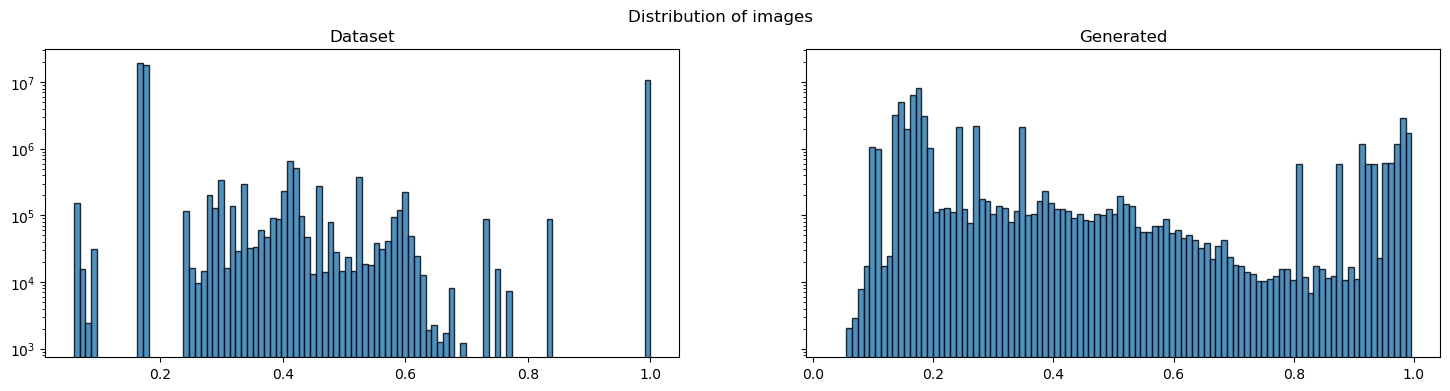

In [28]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(18, 4), sharey=True)
axes[0].hist(X_train_all.flatten(), bins=100, alpha=0.8, edgecolor='black')
        
axes[0].set_title('Dataset')
axes[1].hist(generated_all_images.flatten(), bins=100, alpha=0.8, edgecolor='black')
axes[1].set_title('Generated')
axes[1].semilogy()

plt.suptitle('Distribution of images');


In [29]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'dataset': [X_train_all.mean(), X_train_all.std(), np.quantile(X_train_all, 0.5), X_train_all.min(), X_train_all.max(),
        np.quantile(X_train_all, 0.25), np.quantile(X_train_all, 0.75)],
    'generated': [generated_all_images.mean(), generated_all_images.std(), np.quantile(generated_all_images, 0.5),
        generated_all_images.min(), generated_all_images.max(), np.quantile(generated_all_images, 0.25),
        np.quantile(generated_all_images, 0.75)]
}, index=['mean', 'std', 'median', 'min', 'max', '25% quantile', '75% quantile'])
df

,dataset,generated
mean,0.364613,0.360628
std,0.330093,0.312250
median,0.180420,0.180013
min,0.058838,0.036363
max,1.000000,0.995566
25% quantile,0.168579,0.162237
75% quantile,0.415771,0.411832


In [30]:
recursive_generated_all_images = generator.predict([generated_all_images, X_train_z_all, cX_train_all])

df['recursive gen'] = [recursive_generated_all_images.mean(), recursive_generated_all_images.std(),
    np.quantile(recursive_generated_all_images, 0.5), recursive_generated_all_images.min(), recursive_generated_all_images.max(),
    np.quantile(recursive_generated_all_images, 0.25), np.quantile(recursive_generated_all_images, 0.75)]
df

23/23 [==============================] - 2s 97ms/step


,dataset,generated,recursive gen
mean,0.364613,0.360628,0.371062
std,0.330093,0.312250,0.303449
median,0.180420,0.180013,0.200912
min,0.058838,0.036363,0.091915
max,1.000000,0.995566,0.989322
25% quantile,0.168579,0.162237,0.172399
75% quantile,0.415771,0.411832,0.434200


### GIFs to Visualize Results

The GIFs are generated in grayscale to minimize visual distractions from subtle background color changes (using the `generate_gif_gray` function). To create RGB images, use the `generate_gif` function.

The generated results are saved in the `test_results` folder. To produce additional GIFs with different input samples, simply adjust the sample index `i`.

In [31]:
from skimage import img_as_ubyte
import imageio
import numpy as np

def normalize_image(image):
	return (image - image.min()) / (image.max() - image.min())

def generate_gif(images, name):
    images = [img_as_ubyte(normalize_image(image)) for image in images]
    images = [np.transpose(image, (1, 2, 0)) for image in images]
    imageio.mimsave(SAVE_PATH+f'/{name}_rgb_scale.gif', images)

def generate_gif_gray(images, name):
    images = [img_as_ubyte(normalize_image(np.mean(image, axis=0))) for image in images]
    imageio.mimsave(SAVE_PATH+f'/{name}_gray_scale.gif', images)

In [32]:
for i in [0, 100, 200, 702]:
    # input sequence
    generate_gif_gray(X_train_all[i], f'input_seq_{i}')

    # generated sequence
    generate_gif_gray(X_train_all[i]+generated_all_images[i], f'generated_seq_{i}')

    # recursive generated sequence
    generate_gif_gray(X_train_all[i]+generated_all_images[i]+recursive_generated_all_images[i], f'recursive_generated_seq_{i}')